## **Introduction to ADCNet: Predicting ADC Activity with DeepChem**

Antibody-Drug Conjugates (ADCs) can transform cancer treatment in the era of precision medicine by enabling targeted delivery of potent drugs to cancer cells, minimizing damage to healthy tissues. However, designing effective ADCs remains challenging due to the complex relationship between their molecular structures and therapeutic activities. To address this, we introduce ADCNet [[1]](#1), a unified deep learning framework that facilitates the rational design of ADCs. ADCNet integrates the protein representation learning model ESM-2 for antibody and antigen sequences with the small-molecule representation model FG-BERT for linker and payload SMILES strings, alongside the Drug-Antibody Ratio (DAR) value, to predict ADC activity with high accuracy.

In this tutorial, we will explore how to predict the therapeutic activity of Antibody-Drug Conjugates (ADCs) using ADCNet, a unified deep learning framework implemented in DeepChem. To build a foundational understanding of ADCs, refer to the "Introduction to Antibody-Drug Conjugates" [[2]](#2) notebook available in the DeepChem tutorials before proceeding with this guide.

# **Colab**
This tutorial and the rest in this sequence can be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/ADCNet.ipynb)

## **Background on Drug Discovery and ADCs**

With advancements in molecular biology, target-oriented drug discovery has become the dominant approach, aiming to identify selective and effective clinical candidates. Traditional small molecule inhibitors have shown success but suffer from limitations such as off-target effects, narrow therapeutic windows, and drug resistance. The development of monoclonal antibodies has addressed some of these issues by leveraging specific antigen expression, though their effectiveness against heterogeneous cancer cells remains limited. Antibody-Drug Conjugates (ADCs) emerged as an innovative solution, combining the targeting precision of antibodies with the cytotoxicity of toxins via suitable linkers, enhancing therapeutic efficacy while minimizing harm to healthy cells.

## **Overview of the model architecture**

We have three steps of execution: First is processing different types of input data; second, generating embeddings from these inputs using pretrained models; and lastly, concteanting the embeddings and feeding them into a Multilayer Perceptron (MLP) to predict the outcome.

### Inputs

So lets know about the inputs, we have three different forms of inputs. 

(I) Protein Sequences:

- Antibody Heavy Chain: Protein sequence of the antibody's heavy chain.
- Antibody Light Chain: Protein sequence of the antibody's light chain.
- Antigen: Protein sequence of the target antigen.

(II) Small Molecules (SMILES representations):

- Linker: SMILES string representing the chemical structure of the linker.
- Payload: SMILES string representing the chemical structure of the cytotoxic payload.

(III) Numerical Value:

- Drug–Antibody Ratio (DAR): A value indicating the average number of payload molecules attached to each antibody.

Each input is processed separately to extract its unique features.

### Generating Embeddings

ADCNet uses pre-trained language models to transform the inputs into embeddings:

- Protein sequences (antibody heavy chain, antibody light chain, and antigen sequences) are processed using ESM-2 (Evolutionary Scale Modeling) [[3]](#3), a Transformer-based protein language model. ESM-2 converts these sequences into dense embeddings that encode their structural and functional properties.

- SMILES representations of the linker and payload are processed using ChemBERTA. ChemBERTA generates embeddings that capture the chemical properties of these small molecules. <br>

   **Note**: While the original ADCNet paper used FGBERT, ChemBERTA is utilized here due to its availability and effectiveness in the DeepChem framework.

### Prediction

After generating the embeddings,

- The embeddings from the three protein sequences (heavy chain, light chain, and antigen), the two small molecules (linker and payload), and the processed DAR value are concatenated into a single feature vector.
- This combined feature vector is fed into a Multilayer Perceptron (MLP) consisting of two fully connected layers with nonlinear activation functions. The MLP analyzes the concatenated features to predict the ADC's therapeutic activity.

Below is the architecture diagram of ADCNet, illustrating the complete workflow from input sequences and molecular structures, through embedding layers and model components, to the final prediction output.

<img src="assets/ADCNet_2.png" alt="image2" height = "800" width="800"> <br> **Fig.1** Diagram illustrating the network architecture of ADCNet model. [[4]](#4)

### Setup

Before we proceed, let's install deepchem into our environment and setup other required dependencies.

In [73]:
# install the necessary libraries

!pip install deepchem numpy torch scikit-learn transformers tqdm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from transformers import EsmTokenizer, EsmModel
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

/opt/miniconda3/envs/adcnet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Collection and Pre-Processing

We will be using ADCdb, originally used by ADCNet and accessible at [[5]](#5). It contains data on 6,572 ADCs, including 359 approved by the FDA or in clinical trials, 501 in preclinical testing, 819 with in-vivo testing data, 1,868 with cell line or target testing data, and 3,025 without such testing.

Here, we will be using the preprocessed data for convinience, available at [[6]](#6). Lets take a look at the dataset. The original dataset is ADCdb, a comprehensive collection of data on ADCs. We use the preprocessed version provided by ADCNet, which can be found in the assets folder or in the ADCdb GitHub repository.

In [3]:
# load file
file_path = "assets/adcdb.csv"
df = pd.read_csv(file_path)

print(f'We have data of {len(df)} ADCs.')

We have data of 435 ADCs.


In [4]:
df.columns.to_list()

['index',
 'ADC ID',
 'ADC Name',
 'Antibody Name',
 'Antibody Heavy Chain Sequence',
 'Antibody Light Chain Sequence',
 'Antigen Sequence',
 'Payload Isosmiles',
 'Linker Isosmiles',
 'DAR',
 'label（10nm）',
 'label（100nm）',
 'label（1nm）',
 'label（1000nm）',
 'DAR_val']

We can see the dataset contains columns representing ADC names, antibody sequences, antigen sequences, SMILES strings for linker/payload, and labels at multiple concentrations. Now lets have a preview of the dataset we will be using:

In [77]:
df.head()

,index,ADC ID,ADC Name,Antibody Name,Antibody Heavy Chain Sequence,Antibody Light Chain Sequence,Antigen Sequence,Payload Isosmiles,Linker Isosmiles,DAR,label（10nm）,label（100nm）,label（1nm）,label（1000nm）,DAR_val
0,0,DRG0ABJAM,Trastuzumab-BCN-HydraSpace-Val-Cit-PABC-Gly-Ca...,Trastuzumab,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKL...,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,CCN(C(=O)CN)C1COC(OC2C(OC3C#C/C=C\C#CC4(O)CC(=...,CC(C)C(NC(=O)OCCN(CCOC(=O)NC(C(=O)NC(CCCNC(N)=...,1.86,0,0,0,0,1.86
1,1,DRG0ZBATX,Anti-KIT NEG087?SSNPP-DM3,Anti-KIT mAb NEG087,EVQLVESGGGLVQPGGSLRLSCAASGFTFSDYYMAWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQSISSYLNWYQQKPGKAPKL...,MRGARGAWDFLCVLLLLLRVQTGSSQPSVSPGEPSPPSIHPGKSDL...,C[C@@H]1[C@@H]2C[C@]([C@@H](/C=C/C=C(/CC3=CC(=...,CC(S)CCC(N)=O,3.0-4.0,0,0,0,0,3.50
2,2,DRG0XJKXB,Trastuzumab-C239I-SG3400,Engineered trastuzumab,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKL...,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,C=C1CC2C=Nc3cc(OCCCOc4cc5c(cc4OC)C(=O)N4CC(=C)...,C[C@@H](C(=O)NC1=CC=C(C=C1)CO)NC(=O)[C@H](C(C)...,1.71,1,1,1,1,1.71
3,3,DRG0ZOYQV,Datopotamab deruxtecan,Datopotamab,QVQLVQSGAEVKKPGASVKVSCKASGYTFTTAGMQWVRQAPGQGLE...,DIQMTQSPSSLSASVGDRVTITCKASQDVSTAVAWYQQKPGKAPKL...,MARGPGLAPPPLRLPLLLLVLAAVTGHTAAQDNCTCPTNKMTVCSP...,CC[C@@]1(C2=C(COC1=O)C(=O)N3CC4=C5[C@H](CCC6=C...,C1=CC=C(C=C1)C[C@@H](C(=O)NCC(=O)O)NC(=O)CNC(=...,4,1,1,1,1,4.00
4,4,DRG0COMTY,Telisotuzumab vedotin,Telisotuzumab,QVQLVQSGAEVKKPGASVKVSCKASGYIFTAYTMHWVRQAPGQGLE...,DIVMTQSPDSLAVSLGERATINCKSSESVDSYANSFLHWYQQKPGQ...,MKAPAVLAPGILVLLFTLVQRSNGECKEALAKSEMNVNMKYQLPNF...,CC[C@H](C)[C@@H]([C@@H](CC(=O)N1CCC[C@H]1[C@@H...,CC(C)[C@@H](C(=O)N[C@@H](CCCNC(=O)N)C(=O)NC1=C...,3.1,1,1,1,1,3.10


### Preprocessing Numeric Features

We can see, we have an important feature Drug-Antibody ratio (DAR), which is significant in determining the efficacy and safety of ADCs, as it represents the average number of drug molecules attached to each antibody. Since DAR is a continuous numerical feature, we will scale it before inputting it into our model. Standardizing DAR to have zero mean and unit variance ensures that it is on a comparable scale with other features, which helps neural networks train more efficiently and converge faster.

In [78]:
from sklearn.preprocessing import StandardScaler

# Extract and scale the Drug-Antibody Ratio (DAR)

dar_values = df['DAR_val'].values.reshape(-1, 1)
scaler = StandardScaler()
dar_scaled = scaler.fit_transform(dar_values)

Let's preview the first five scaled DAR values.

In [79]:
dar_scaled[:5]

array([[-1.28000061],
       [-0.2348211 ],
       [-1.3755963 ],
       [ 0.08383119],
       [-0.48974293]])

Now that our data is preprocessed and the Drug–Antibody Ratio (DAR) values are standardized, we are ready to generate embeddings using pre-trained models for each input type.

### Generating Embeddings with Pretrained Models

Set up the computation device (GPU if available, otherwise CPU) and import necessary transformer modules.

In [80]:
from transformers import EsmTokenizer, EsmModel, AutoTokenizer, AutoModel
import torch

# Choose device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Before we move further, ESM-2 (Evolutionary Scale Modeling) is a protein language model using a transformer-based architecture to process protein sequences. It has been trained on large datasets of protein sequences to learn the relationships between amino acids and the structural and functional properties of proteins.

ESM-2 has demonstrated strong performance across various protein-related prediction tasks, making it a reliable choice for encoding protein sequences in deep learning workflows. To explore ESM-2 and other protein language models developed by Meta’s FAIR (Fundamental AI Research) team, visit the official GitHub repository [here](https://github.com/facebookresearch/esm).

Here we use the smallest ESM-2 model (esm2_t6_8M_UR50D, 6 layers, 8M parameters) for protein sequence embeddings. Larger ESM-2 models are available in the [Hugging Face Model Hub](https://huggingface.co/facebook/esm2_t6_8M_UR50D) for improved accuracy at the cost of increased computational resources.

In [81]:
# Load ESM-2 for protein sequences

esm_model_id = 'facebook/esm2_t6_8M_UR50D'
tokenizer_esm = EsmTokenizer.from_pretrained(esm_model_id)
esm = EsmModel.from_pretrained(esm_model_id).to(device)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


For small molecules like payloads and linkers, we will use ChemBERTa to generate embeddings from the SMILES strings of payloads and linkers. ChemBERTa is a Transformer-based model pre-trained on chemical SMILES, enabling it to capture the structural and chemical properties of small molecules for downstream tasks.

In [82]:
#  Load the ChemBERTa model and tokenizer

model_chemberta = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer_chemberta = AutoTokenizer.from_pretrained(model_chemberta)
chemberta = AutoModel.from_pretrained(model_chemberta)

Now we have initialized two Transformer-based models: ESM-2 for protein sequences, and ChemBERTa for SMILES. Loading them onto the computation device allows fast embedding extraction.

We will now generate embeddings for the antibody heavy chain, light chain, and antigen protein sequences in our dataset using ESM-2. These embeddings capture the structural and functional properties of each protein sequence, enabling the model to learn meaningful biological representations for downstream prediction tasks.

In [83]:
# Extract sequences and SMILES from the dataframe

heavy_chains = df['Antibody Heavy Chain Sequence'].astype(str).tolist()
light_chains = df['Antibody Light Chain Sequence'].astype(str).tolist()
antigens = df['Antigen Sequence'].astype(str).tolist()
linkers = df['Linker Isosmiles'].tolist()
payloads = df['Payload Isosmiles'].tolist()

Let's first generate embeddings from protein sequences using ESM-2

In [84]:
MAX_SEQ_LENGTH = 1500

# Function to get embeddings from protein sequences
def get_embeddings(sequences):
    embeddings = []

    for seq in tqdm(sequences, desc="Generating embeddings"):
        inputs = tokenizer_esm(
            seq,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
            max_length=MAX_SEQ_LENGTH,
            is_split_into_words=False
        )

        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = esm(**inputs)
        
        # Extract CLS token
        cls_emb = outputs.last_hidden_state[:, 0, :].squeeze().cpu()
        embeddings.append(cls_emb)

    return embeddings

Now we can use the above function to generate embeddings for our protein sequences (heavy chains, light chains, and antigens) by passing the corresponding sequence lists as input.

In [85]:
# Generate embeddings from protein sequences
print("Generating embeddings for heavy chains, light chains, and antigens...")

heavy_embeddings = get_embeddings(heavy_chains)
light_embeddings = get_embeddings(light_chains)
antigen_embeddings = get_embeddings(antigens)

Generating embeddings for heavy chains, light chains, and antigens...


Generating embeddings: 100%|██████████| 435/435 [04:16<00:00,  1.70it/s]


Now let's generate embeddings for the payload and linker SMILES strings using ChemBERTa.

In [86]:
# Function to get embedding for a single SMILES string
def get_smiles_embedding(smiles: str):
    inputs = tokenizer_chemberta(smiles, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = chemberta(**inputs)
        # Use the CLS token representation (first token)
        embedding = outputs.last_hidden_state[:, 0, :]  # shape: (1, hidden_size)
        return embedding.squeeze().cpu().numpy()

The above function now can be used to generate a ChemBERTa embedding for a single SMILES string, which can be used for both linker and payload molecules. <br>Lets see taking an example:

In [87]:
example = payloads[0]
print(example)

CCN(C(=O)CN)C1COC(OC2C(OC3C#C/C=C\C#CC4(O)CC(=O)C(NC(=O)OC)=C3/C4=C\CSSC(C)(C)CC(=O)NCCOCCOC)OC(C)C(NOC3CC(O)C(SC(=O)c4c(C)c(I)c(OC5OC(C)C(O)C(OC)C5O)c(OC)c4OC)C(C)O3)C2O)CC1OC


In [88]:
example_embedding = get_smiles_embedding(example)
print(f"Embedding shape for example payload: {example_embedding.shape}")

Embedding shape for example payload: (768,)


Now that we understand how to generate embeddings from SMILES strings, let's create embeddings for all linker and payload molecules in the dataset.

In [89]:
# Function to generate embeddings for a list of SMILES

def generate_embeddings(smiles_list):
    """Generate embeddings for a list of SMILES strings."""
    embeddings = []
    for smi in tqdm(smiles_list):
        try:
            emb = get_smiles_embedding(smi)
            embeddings.append(emb)
        except Exception as e:
            print(f"Failed for {smi}: {e}")
            embeddings.append(None)
    return embeddings

As we have defined the function above, we can now pass our Payload SMILES string to generate embeddings. This process transforms each payload molecule into a numerical vector representation that captures its chemical properties.

In [90]:
payload_embeddings = generate_embeddings(payloads) # embeddings from payload smiles

100%|██████████| 435/435 [00:13<00:00, 32.63it/s]


Similarly, we can get embeddings from linker smiles:

In [91]:
linker_embeddings = generate_embeddings(linkers) # embeddings from linker smiles

100%|██████████| 435/435 [00:08<00:00, 50.31it/s]


Now that we’ve generated embeddings from all protein sequences, as well as the payload and linker SMILES, we can concatenate them, along with the standardized DAR value to form a complete feature vector for each ADC.

In [92]:
import torch

adc_embeddings = []

num_adcs = len(heavy_embeddings)

for i in range(num_adcs):
    heavy = heavy_embeddings[i]
    light = light_embeddings[i]
    antigen = antigen_embeddings[i]
    payload = payload_embeddings[i]
    linker = linker_embeddings[i]
    dar = dar_scaled[i]

    # Convert to tensor and ensure 1D
    for name, emb in zip(['heavy', 'light', 'antigen', 'dar'], [heavy, light, antigen, dar]):
        if not isinstance(emb, torch.Tensor):
            emb = torch.tensor(emb, dtype=torch.float32)
        if emb.dim() == 0:
            emb = emb.unsqueeze(0)
        elif emb.dim() > 1:
            emb = emb.squeeze()
        locals()[name] = emb

    for name, emb in zip(['payload', 'linker'], [payload, linker]):
        if not isinstance(emb, torch.Tensor):
            emb = torch.tensor(emb, dtype=torch.float32)
        if emb.dim() == 0:
            emb = emb.unsqueeze(0)
        elif emb.dim() > 1:
            emb = emb.squeeze()
        locals()[name] = emb

    # Concatenate all embeddings
    full_emb = torch.cat([
        heavy,
        light,
        antigen,
        payload,
        linker,
        dar
    ])  # shape: [combined_dim]

    adc_embeddings.append(full_emb)

Now, lets check the embedding shape of each input we have generated. 

In [93]:
print("Payload shape:", payload_embeddings[0].shape)
print("Linker shape:", linker_embeddings[0].shape)
print("Heavy shape:", heavy_embeddings[0].shape)
print("Light shape:", light_embeddings[0].shape)
print("Antigen shape:", antigen_embeddings[0].shape)
print("DAR shape:", dar_scaled[0].shape)

Payload shape: (768,)
Linker shape: (768,)
Heavy shape: torch.Size([320])
Light shape: torch.Size([320])
Antigen shape: torch.Size([320])
DAR shape: (1,)


Lets see the shape of a single concatenated ADC embedding i.e., feature vector for one ADC.

In [94]:
full_emb.shape

torch.Size([2497])

Now, we can check the shape of the full batch tensor (i.e., all ADCs stacked), where the first dimension is the number of ADCs and the second is the embedding size.

In [95]:
adc_batch_tensor = torch.stack(adc_embeddings)
adc_batch_tensor.shape

torch.Size([435, 2497])

#### Defining MLP (Multi-Layer Perceptron)

Before we move into model training, it’s important to understand the architecture of the MLP (Multi-Layer Perceptron). An MLP is a type of feedforward neural network consisting of an input layer, one or more hidden layers, and an output layer. Each neuron in a layer is fully connected to every neuron in the next, allowing the model to learn complex, non-linear patterns from the data.  Other inputs include Dropout and Activation function. Dropout randomly disables a fraction of neurons during each training iteration, which forces the network to not rely too heavily on any one neuron and helps in learning more robust features, and activation function is used to specify the activation function used in the hidden layers of the model. <br>

In our setup, the input layer has a dimension of 2497, which corresponds to the size of the combined embeddings. This is followed by 2 hidden layers that help the model extract deeper hierarchical features, and finally, an output layer that produces predictions. Other inputs includes a dropout rate of 0.2 and Relu activation function.

In [ ]:
import torch
import torch.nn as nn
from deepchem.models.torch_models.layers import MultilayerPerceptron

# Define the model
model_mlp = MultilayerPerceptron(
    d_input= 2497,
    d_output=1,
    d_hidden=(1024, 256),
    dropout=0.2,
    activation_fn='relu'
)

# Forward pass
op = model_mlp(adc_batch_tensor)
print(op.shape)  # [435, 1]

torch.Size([435, 1])


We will be using the 100 nm label from the dataset as our target variable. Although the dataset also includes labels at 10 nm and 1000 nm, we choose the 100 nm label.

In [ ]:
# Now extract the label
label_col = "label (100nm) "
labels = df[label_col].values  # 0 or 1

# Convert to PyTorch tensor
y = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

In [99]:
X_train, X_val, y_train, y_val = train_test_split(adc_batch_tensor, y, test_size=0.2, random_state=42)

Let's define the model, loss function, and optimizer that we'll be using for training.

In [100]:
# Model, Loss, Optimizer
mode = model_mlp 
criterion = nn.MSELoss()
optimizer = optim.Adam(mode.parameters(), lr=1e-4)

We'll train the model on the training set and evaluate its performance on the validation set across multiple epochs.

In [ ]:
# Here, we define two lists to store the training and validation loss values after each epoch.

train_losses = []
val_losses = [] 

# Training Loop

epochs = 100
for epoch in range(epochs):
    model_mlp.train()
    optimizer.zero_grad()

    outputs = mode(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    model_mlp.eval()
    with torch.no_grad():
        val_outputs = model_mlp(X_val)
        val_loss = criterion(val_outputs, y_val)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

Epoch 0 | Train Loss: 0.5286 | Val Loss: 0.2348
Epoch 10 | Train Loss: 0.1894 | Val Loss: 0.1739
Epoch 20 | Train Loss: 0.1718 | Val Loss: 0.1606
Epoch 30 | Train Loss: 0.1564 | Val Loss: 0.1559
Epoch 40 | Train Loss: 0.1428 | Val Loss: 0.1540
Epoch 50 | Train Loss: 0.1301 | Val Loss: 0.1508
Epoch 60 | Train Loss: 0.1171 | Val Loss: 0.1492
Epoch 70 | Train Loss: 0.1048 | Val Loss: 0.1461
Epoch 80 | Train Loss: 0.0935 | Val Loss: 0.1436
Epoch 90 | Train Loss: 0.0849 | Val Loss: 0.1392


As shown above, we can see the training and validation loss over epochs, notice that we have a high training loss at early stage of training the model. But the training loss and validation loss are decreasing over time, which implies the model is generalizing well to unseen data.

Let's check out the first 5 predictions from the MLP model on the validation set.

In [ ]:
model_mlp.eval()
with torch.no_grad():
    preds = model_mlp(X_val)
    print(preds[:5])

tensor([[0.8605],
        [0.8766],
        [0.0816],
        [0.8850],
        [0.8774]])


So, now lets check, our predicted values with our actual labels, to get insights how well the model is performing, and gain insights into the prediction quality.

In [104]:
print("Predictions:", val_outputs.squeeze().tolist())
print("Ground Truth:", y_val.squeeze().tolist())

Predictions: [0.8604627847671509, 0.8766361474990845, 0.08158807456493378, 0.8850487470626831, 0.8773857355117798, 0.6256274580955505, 1.0221673250198364, 1.0143158435821533, 0.07451888918876648, 1.142587423324585, 1.0889818668365479, 0.6264299154281616, 0.7104624509811401, 0.5979621410369873, 1.034963846206665, 0.5438574552536011, 1.0235146284103394, 0.45695167779922485, 0.7676084041595459, 1.0152987241744995, 0.8191136121749878, 0.2315719574689865, 0.3031579256057739, 0.9687270522117615, 0.8722743988037109, 0.6043841242790222, 0.7275203466415405, 0.0761025920510292, 0.9894317388534546, 0.061810679733753204, 0.25799688696861267, 0.19271910190582275, 0.3563591241836548, 0.8409030437469482, 0.6885155439376831, 0.19129197299480438, 0.1649983823299408, 0.618075430393219, 1.0030666589736938, 0.5772683024406433, 0.9546897411346436, 0.6555521488189697, 0.5921096801757812, 0.36422061920166016, 0.280250608921051, 0.9707998037338257, 0.8370811939239502, 0.921593189239502, 1.018582820892334, 0.3

Finally, let's plot the loss curve to get better insights on our training and validation loss over epochs. So, visualizing the training and validation loss curves is necessary and helps us understand how well the model is learning over time. A steadily decreasing training loss indicates that the model is fitting the data, while the validation loss provides insight into how well the model generalizes to unseen data. If the validation loss starts increasing while the training loss continues to decrease, it may indicate overfitting. By examining these curves, we can diagnose issues such as underfitting, overfitting, or the need for further hyperparameter tuning.

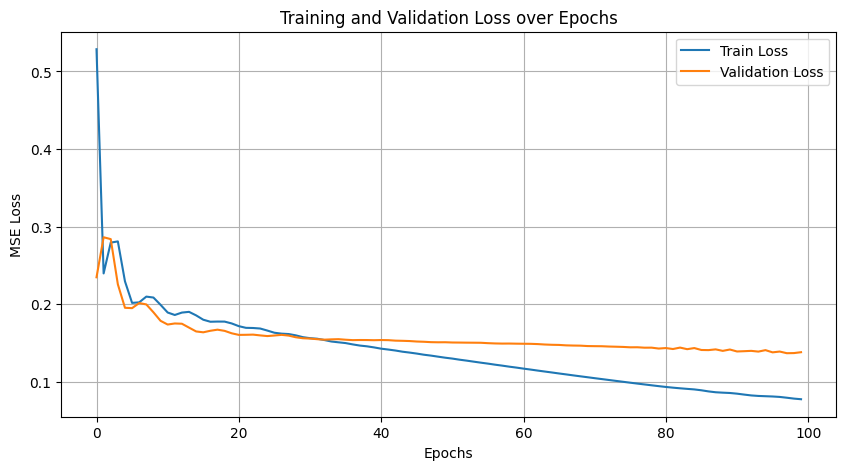

In [105]:
# Plotting loss curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

It's time to check the accuracy of our model. So, accuracy is measured as the proportion of correct predictions (where the predicted label matches the true label) out of the total number of samples in the validation set.

In [106]:
predicted_labels = torch.round(val_outputs.squeeze())  # round to 0 or 1
true_labels = y_val.squeeze()


correct = (predicted_labels == true_labels).sum().item()
total = true_labels.size(0)

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 82.76%


## References <a name="references"></a>

<a name="1"></a> [1] Chen, L., Li, B., Chen, Y., Lin, M., Zhang, S., Li, C., Pang, Y., & Wang, L. (2024). ADCNet: A unified framework for predicting the activity of antibody‑drug conjugates. https://arxiv.org/pdf/2401.09176

<a name="2"></a> [2] DeepChem Team. (n.d.). Introduction to Antibody-Drug Conjugates. https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Introduction_to_Antibody_Drug_Conjugates.ipynb

<a name="3"></a> [3] Facebook AI Research. (2020). ESM: Evolutionary Scale Modeling [GitHub repository]. https://github.com/facebookresearch/esm

<a name="4"></a> [4] ADCNet githubidrugLab.(2024). ADCNet: a unified framework for predicting the activity of antibody‑drug conjugates. GitHub repository: https://github.com/idrugLab/ADCNet

<a name="5"></a> [5] Shen, L. T., Sun, X. N., Chen, Z., Guo, Y., Shen, Z. Y., Song, Y., Xin, W. X., Ding, H. Y., Ma, X. Y., Xu, W. B., Zhou, W. Y., Che, J. X., Tan, L. L., Chen, L. S., Chen, S. Q., Dong, X. W., Fang, L., & Zhu, F. (2024).
ADCdb: the database of antibody‑drug conjugates. Nucleic Acids Research, 52(D1), D1097–D1109. PMID 37831118.
Website: https://adcdb.idrblab.net/

<a name="6"></a> [6] ADCNet githubidrugLab.(2024). ADCNet: a unified framework for predicting the activity of antibody‑drug conjugates. GitHub repository: https://github.com/idrugLab/ADCNet

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Discord
The DeepChem [Discord](https://discord.gg/5d5bEVSt) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

# Citing this tutorial
If you found this tutorial useful please consider citing it using the provided BibTeX.

```
@manual{Molecular Machine Learning,
 title={Introduction to ADCNet: Predicting ADC Activity with DeepChem},
 organization={DeepChem},
 author={Patra, Sonali Lipsa, and Singh, Rakshit Kr. and Bisoi, Ankita and Ramsundar, Bharath}
 howpublished = {\url{https://github.com/deepchem/deepchem/blob/master/examples/tutorials/ADCNet.ipynb}},
 year={2025},
}
```